In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
ed = tfp.edward2
import sys
sys.path.append("../")
from future_features import tape
import numpy as np
#from plot_utils import plot_source_distributions, plot_ifa_parameters_and_ppc


In [2]:
#from testsuite import MAP_model, neg_log_lik

In [3]:
from tfpmodels import *
from mapper import Mapper, IFA_MAPEM

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import FastICA, PCA

/home/rabo/anaconda3/envs/tfp/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/rabo/anaconda3/envs/tfp/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/rabo/anaconda3/envs/tfp/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/rabo/anaconda3/envs/tfp/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/rabo/anaconda3/envs/tfp/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  retu

In [5]:
sess = tf.InteractiveSession()

In [6]:
n_components_in_mixture = 2
n_sources = 3
n_features = 33
n_observations = 1000

In [7]:
ifa_data = Mapper(centeredMarginalizedIndependentFactorAnalysis, 'ifa1', ['data'], n_observations=n_observations, n_components_in_mixture=n_components_in_mixture, n_features=n_features, n_sources=n_sources, mixture_component_var_concentration=3., mixture_component_var_rate=2.,data_var_concentration=3.,data_var_rate=1.)
#ifa_data = Mapper(mixtureOfGaussians, 'mog', observed_variable_names=['data'], n_observations=n_observations, n_components=4, n_features=n_features,mixture_component_means_var=0.1)
ifa_model = IFA_MAPEM(centeredMarginalizedIndependentFactorAnalysis, 'ifa2', ['data'], n_observations=n_observations, n_components_in_mixture=n_components_in_mixture, n_features=n_features, n_sources=n_sources, mixture_component_var_concentration=3., mixture_component_var_rate=1.,data_var_concentration=3.,data_var_rate=1.)

In [8]:
generated = sess.run(ifa_data.tape)

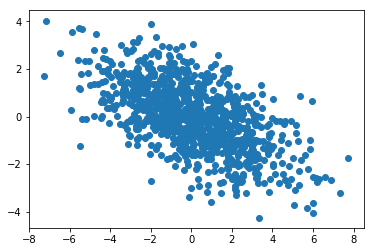

In [10]:
plt.scatter(*generated['data'][:,:2].T)

In [13]:
loss, reset, emstep = ifa_model.MAPEM_optimizer(data=generated['data'])
_, bfgs = ifa_model.bfgs_optimizer(enhanced=False,data=generated['data'])
emproposal = ifa_model.MAPEMsteps(data=generated['data'])
unitsteps = {key: ifa_model.assigner(**{key:val}) for key, val in emproposal.items()}
testmodel = ifa_model.test_model()#centeredMarginalizedIndependentFactorAnalysisTest(n_observations=n_observations, **ifa_model.variables)

In [14]:
grad = {key: tf.gradients(loss, val) for key, val in ifa_model.variables.items()}
cmap = plt.cm.Reds

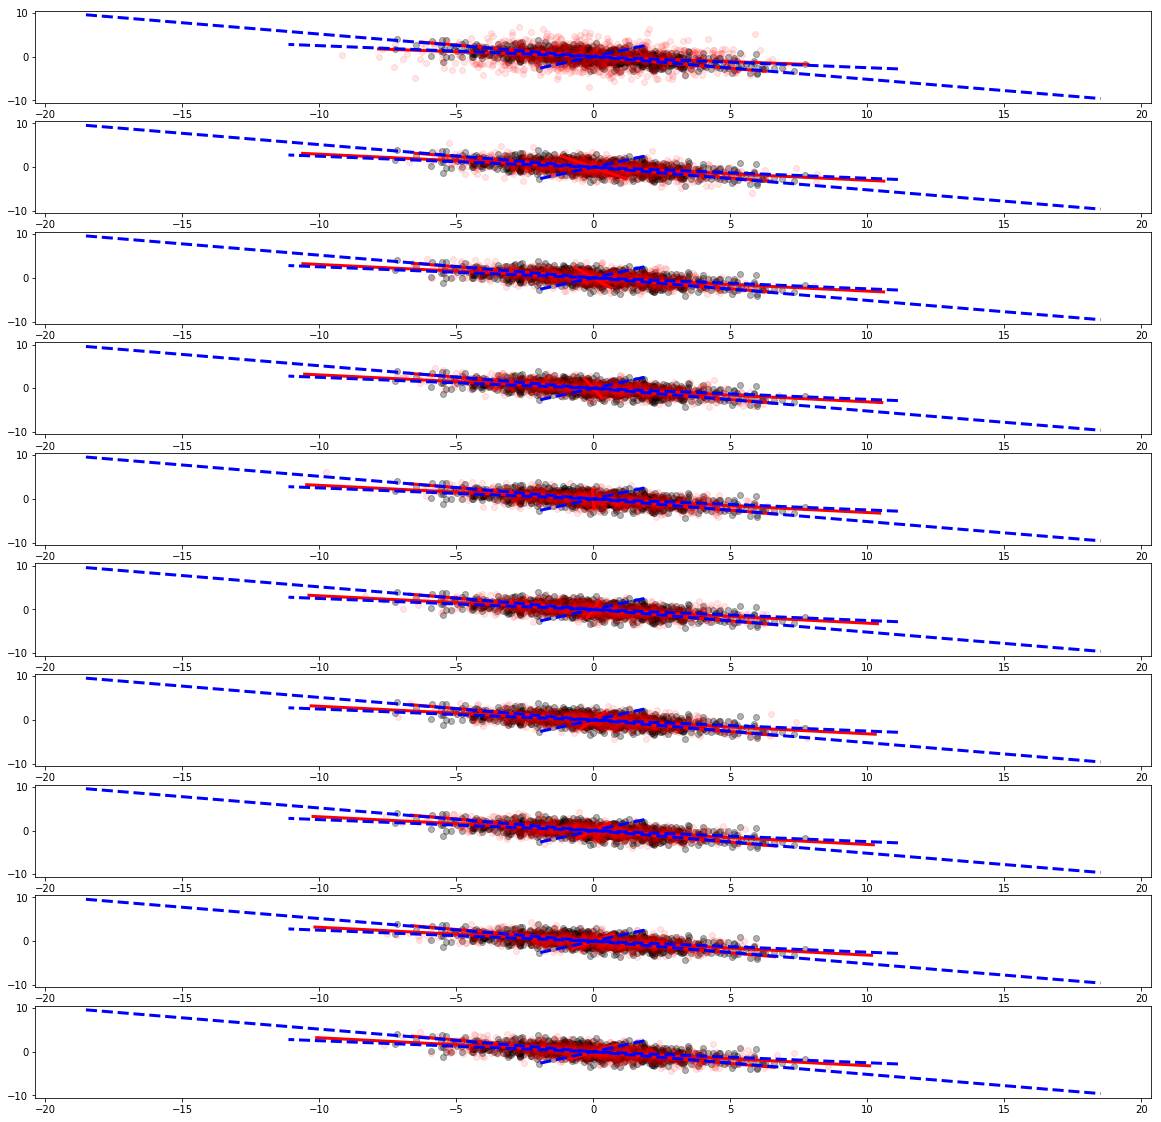

In [17]:
sess.run(tf.global_variables_initializer())
#init = dict(generated)
#init.pop('data')

#sess.run(ifa_model.assigner(**init))
subset = dict(unitsteps)
subset.pop('data_var')

its = 500
losses = [sess.run(loss)]
grads = {key: [] for key in ifa_model.variables.keys()}
loadings = []
plt.figure(figsize=(20,20))
for i in range(its):
    sess.run(reset)
    #sess.run(unitsteps['data_var'])
    #sess.run(reset)
    sess.run(subset)
    if (i % 50) == 0:
        sess.run(unitsteps['data_var'])
    
    #sess.run(unitsteps['mixture_weights'])
    loadings.append(sess.run(ifa_model.variables['factor_loadings']))
    #sess.run(reset)
    #sess.run(unitsteps['mixture_weights'])
    #sess.run(reset)
    #sess.run(unitsteps['data_var'])
    #print(sess.run(ifa_model.current['data_var']))
    loss_i,grad_i = sess.run([loss,grad])
    losses.append(loss_i)
    for key, val in grad_i.items():
        grads[key].append(np.max(np.abs(val)))
    if (i % 50) == 0:
        plt.subplot(its//50,1,i//50+1)
        plt.scatter(*generated['data'][:,:2].T,color='k',alpha=0.3)
        plt.scatter(*sess.run(testmodel)[:,:2].T,alpha=0.1,color='r')
        for l in loadings[-1]:
            plt.plot([-10*l[0],10*l[0]],[-10*l[1],10*l[1]],'r',lw=3)
        for l in generated['factor_loadings']:
            plt.plot([-10*l[0],10*l[0]],[-10*l[1],10*l[1]],'b--',lw=3)
#plt.axis([-5,5,-3,3])

In [18]:
plt.scatter(*generated['data'].T,color='k',alpha=0.3)
plt.scatter(*sess.run(testmodel).T,alpha=0.1,color='r')
for l in loadings[-1]:
    plt.plot([-10*l[0],10*l[0]],[-10*l[1],10*l[1]],'r',lw=3,label='MAP')
for l in generated['factor_loadings']:
    plt.plot([-10*l[0],10*l[0]],[-10*l[1],10*l[1]],'b--',lw=3,label='True')
plt.legend()

TypeError: scatter() got multiple values for argument 'alpha'

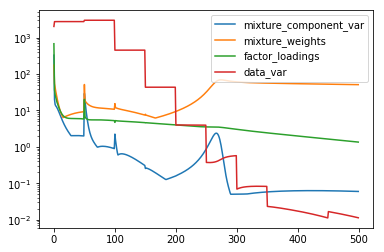

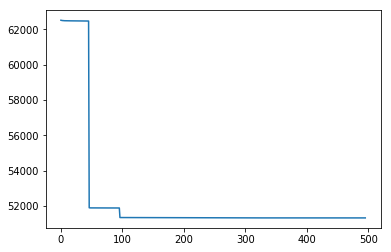

In [21]:
for key, val in grads.items():
    plt.semilogy(val, label=key)
plt.legend()
plt.figure()
plt.plot(losses[5:])
## sign checks
#plt.figure()
#plt.plot((np.diff(losses)))
#plt.hlines(0,0,100)
#plt.ylim([-1,1])
#plt.figure()
#plt.plot(np.sign(np.diff(losses)))
#plt.hlines(0,0,100)
